**Part A: Data Loading and Preparation**

Prepare the CIFAR-10 dataset for training and testing by following these steps.
1. Load Dataset: Use torchvision.datasets.CIFAR10 to load the training and testing sets. Randomly split the
test set into two equal halves: one for validation and one for testing.
2. Data Transformation: Define a transformation pipeline that converts images to PyTorch tensors and then
normalizes them using a mean of [0.4914, 0.4822, 0.4465] and a standard deviation of [0.2470, 0.2435,
0.2616].
3. DataLoaders: Create DataLoader for the training, validation and testing sets, each with a batch size of 64.


**PartA_Data_Loader.py**

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

def get_dataloaders(batch_size=64):
    # prepare
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                            std=[0.2470, 0.2435, 0.2616])
    ])

    # download
    train_set = torchvision.datasets.CIFAR10(root='./data',train=True, download=True,transform=transform)
    test_set = torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transform)

    # divide into validation set and test set
    val_size = len(test_set)//2
    test_size = len(test_set) - val_size
    val_set, test_set = random_split(test_set, [val_size, test_size])

    # create data loaders
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

    return train_loader, val_loader, test_loader

**Part B: MLP Implementation and Training**

First, you will build and train a standard MLP model.
Model Architecture. Implement an MLP that takes a flattened CIFAR-10 image (3 × 32 × 32 = 3072 features) as
input. The network should have the following structure:
a) First, a fully connected layer with 1024 output units, followed by a ReLU activation and a dropout layer (p = 0.5).
b) Next, a fully connected layer with 512 output units, followed by a ReLU activation and a dropout layer (p = 0.5).
c) A fully connected layer mapping to the 10 CIFAR-10 classes.
1Training and Evaluation. Train the model for 10 epochs using the Adam optimizer (torch.optim.Adam) with
a learning rate of 0.001 and weight decay of 0.0001 and the Cross-Entropy Loss function (nn.CrossEntropyLoss).
During training, record the training loss, validation loss, training accuracy, and validation accuracy for each epoch.

**PartB_MLP.py**

In [ ]:
from PartA_Data_Loader import get_dataloaders
import torch
import torch.nn as nn
from train import train_model
from plot import plot_history
from evaluation import evaluate
from evaluation import count_parameters

import os
'''
    OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
    OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program. That is dangerous, since it can degrade performance or cause incorrect results. The best thing to do is to ensure that only a single OpenMP runtime is linked into the process, e.g. by avoiding static linking of the OpenMP runtime in any library. As an unsafe, unsupported, undocumented workaround you can set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, but that may cause crashes or silently produce incorrect results. For more information, please see http://www.intel.com/software/products/support/.
'''
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        # keep batch size, other dimensions flattened
        x = x.view(x.size(0), -1)
        '''
        Requirements:
            a) First, a fully connected layer with 1024 output units, followed by a ReLU activation and a dropout layer (p = 0.5).
            b) Next, a fully connected layer with 512 output units, followed by a ReLU activation and a dropout layer (p = 0.5).
            c) A fully connected layer mapping to the 10 CIFAR-10 classes.
        '''
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


if __name__ == "__main__":
    train_loader, val_loader, test_loader = get_dataloaders(batch_size=64)
    mlp = MLP()
    mlp_history = train_model(mlp, train_loader, val_loader, epochs=10)
    torch.save(mlp.state_dict(), "mlp_model.pth")
    torch.save(mlp_history, "mlp_history.pth")
    plot_history(mlp_history, save_path="mlp_training_curves.png")
    print("MLP parameters: ", count_parameters(mlp))
    test_loss, test_acc = evaluate(mlp, test_loader)
    print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.3f}")

**train.py**

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_model(model, train_loader, val_loader, epochs=10, lr=0.001, weight_decay=0.0001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        # train
        model.train()
        total_loss, correct, total = 0, 0, 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Training]"):
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, pred = out.max(1)  # label: choose the class with the highest probability
            correct += pred.eq(y).sum().item()
            total += y.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        # validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item()
                _, pred = out.max(1)
                correct += pred.eq(y).sum().item()
                total += y.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        tqdm.write(f"Epoch {epoch + 1}/{epochs}\n"
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.3f}\n"
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.3f}"
              )
    return history

**evaluation.py**

In [ ]:
import torch
import torch.nn as nn

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def evaluate(model, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            out = model(x)
            loss = criterion(out, y)
            test_loss += loss.item()
            _, pred = out.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)
    test_loss /= len(test_loader)
    test_acc = correct / total
    return test_loss, test_acc

**plot.py**

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, save_path="training_curves.png"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    print(f"Train curves saved to {save_path}")

**PartB Result:**

Trial (1)
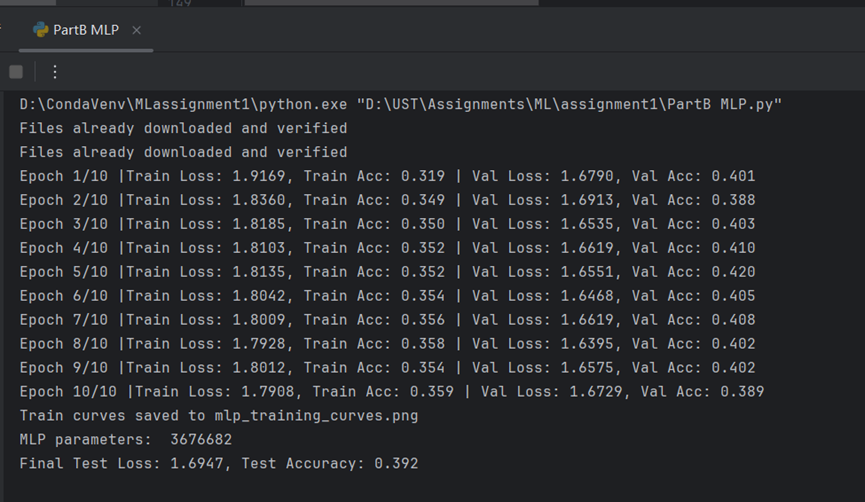
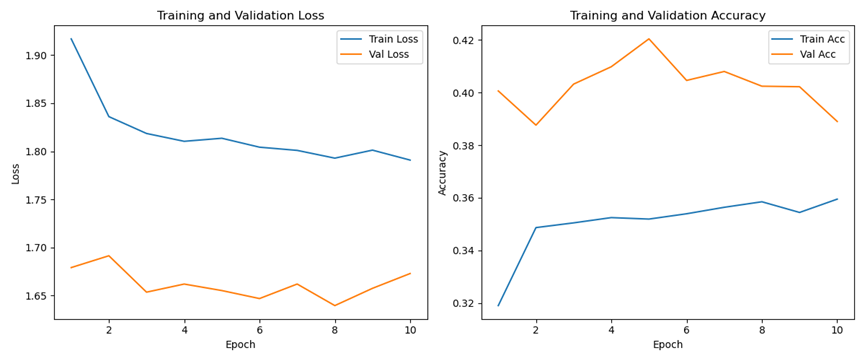
Trial (2)
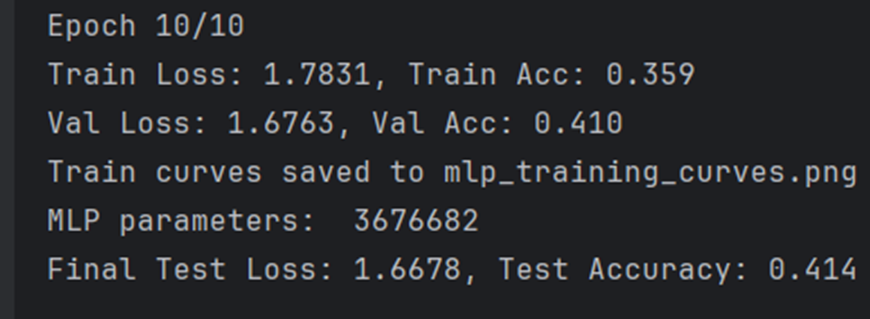
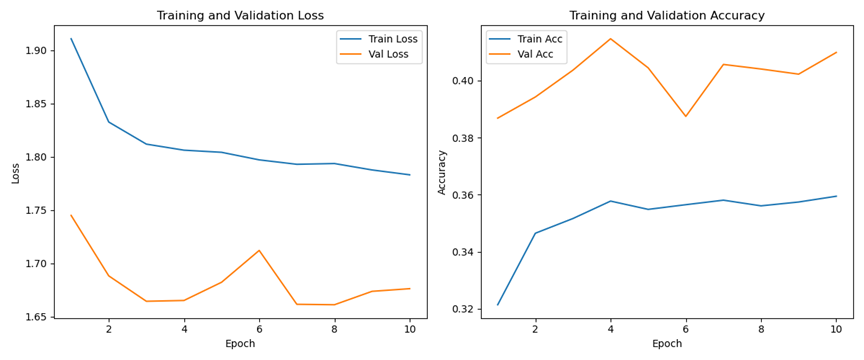
Trial (3)
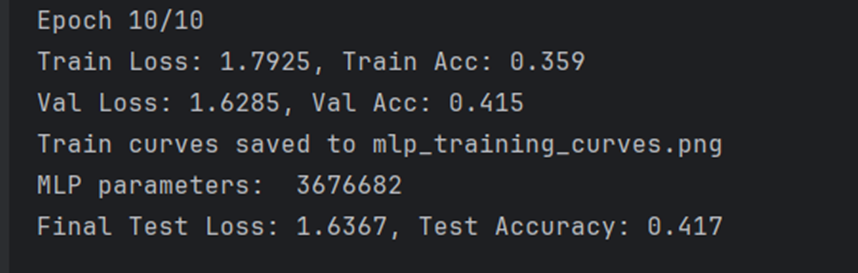
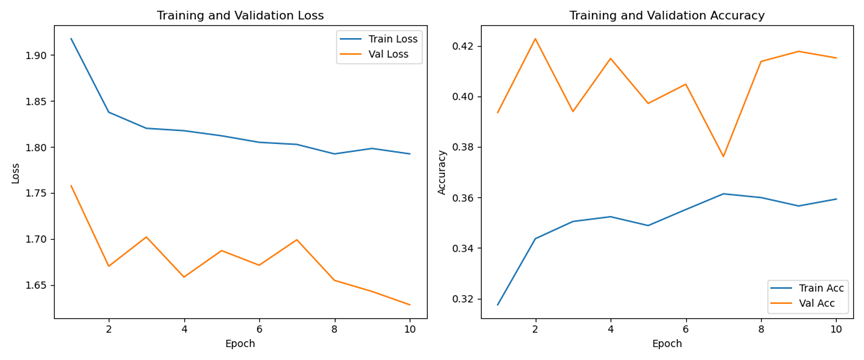
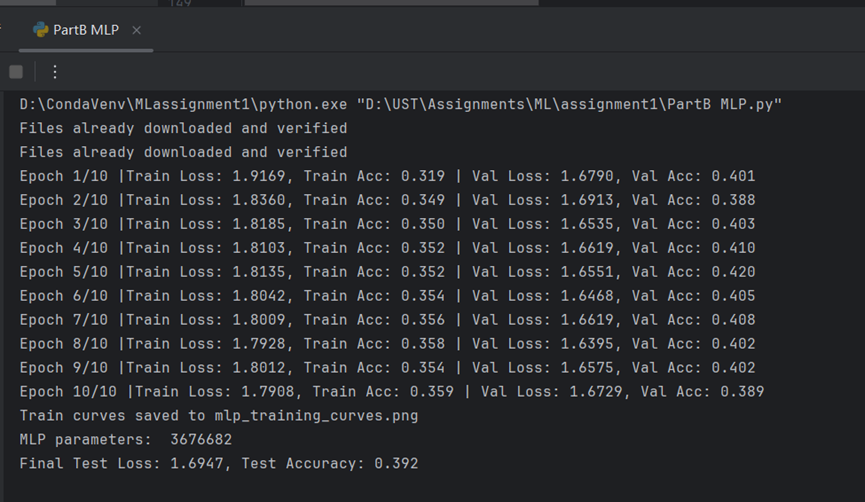
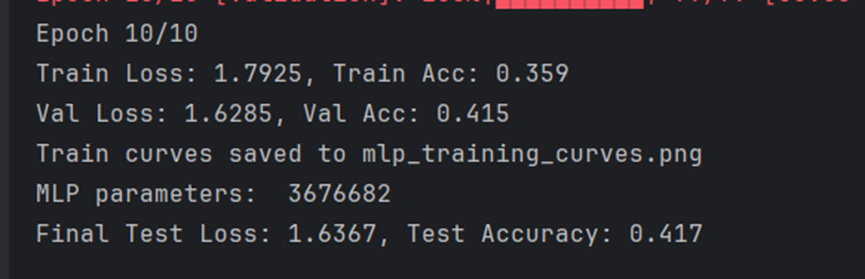

**Part C: CNN Implementation and Training**

Next, you will build and train a simple CNN model.
Model Architecture. Implement a CNN that takes the original 3 × 32 × 32 image tensor as input. The network
should have the following architecture:
[Block 1]
• A convolution layer: 3 input channels, 32 output channels, kernel size 3 × 3, zero-padding 1.
• ReLU activation
• A max-pooling layer: kernel size 3 × 3, stride 2.
[Block 2]
• A convolution layer: 32 input channels, 64 output channels, kernel size 3 × 3, zero-padding 1.
• ReLU activation
• A max-pooling layer: kernel size 2 × 2, stride 2.
[Classifier Head]
• Flatten the output from block 2.
• A fully-connected layer projecting to 512 features, followed by a ReLU activation and a dropout layer (p = 0.5).
• A fully-connected layer mapping to the 10 classes.
Training and Evaluation. Train the CNN using the identical setup as the MLP. Record the same set of metrics
(training/validation loss and accuracy) for each epoch.

**PartC_CNN.py**

In [ ]:
from PartA_Data_Loader import get_dataloaders
import torch
import torch.nn as nn
from train import train_model
from plot import plot_history
from evaluation import evaluate
from evaluation import count_parameters

import os
'''
    OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
    OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program. That is dangerous, since it can degrade performance or cause incorrect results. The best thing to do is to ensure that only a single OpenMP runtime is linked into the process, e.g. by avoiding static linking of the OpenMP runtime in any library. As an unsafe, unsupported, undocumented workaround you can set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, but that may cause crashes or silently produce incorrect results. For more information, please see http://www.intel.com/software/products/support/.
'''
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input size: (batch_size, 3, 32, 32)
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        '''
            Input size: H * W = 32 * 32
            MaxPool2d output size: H + 2 * padding - dilation * (kernel_size - 1) / stride + 1
            padding is 0, dilation is 1
        '''
        # After block1, the shape of the tensor is (batch_size, 32, 15, 15)
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # After block2, the shape of the tensor is (batch_size, 64, 7, 7)
        self.fc1 = nn.Linear(64*7*7, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

if __name__ == "__main__":
    cnn = CNN()
    train_loader, val_loader, test_loader =get_dataloaders(batch_size=64)
    cnn_history = train_model(cnn, train_loader, val_loader, epochs=10, lr=0.001, weight_decay=0.0001)
    torch.save(cnn.state_dict(), "cnn_model.pth")
    torch.save(cnn_history, "cnn_history.pth")
    plot_history(cnn_history, save_path="cnn_training_curves.png")
    print("CNN parameters: ", count_parameters(cnn))
    test_loss, test_acc = evaluate(cnn, test_loader)
    print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.3f}")

**PartC Result:**

Trial (1)
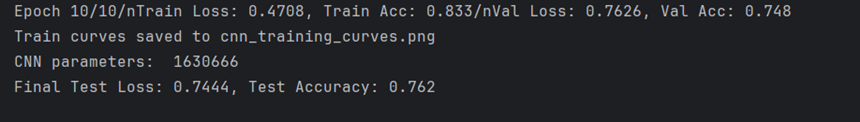
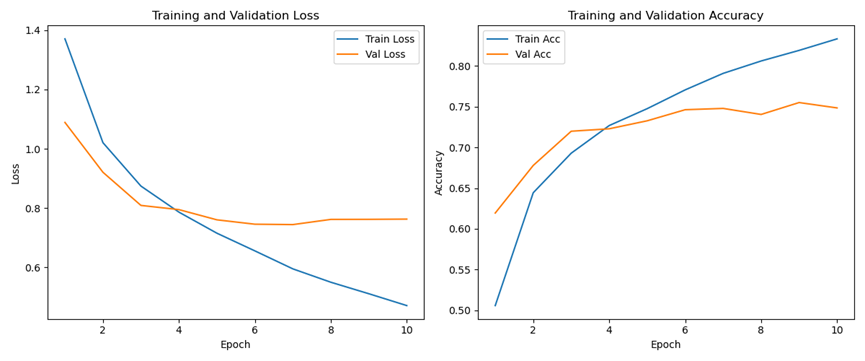
Trial (2)
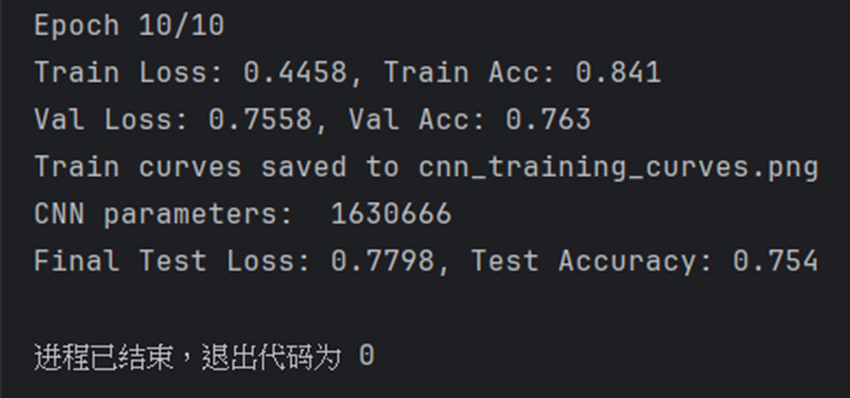
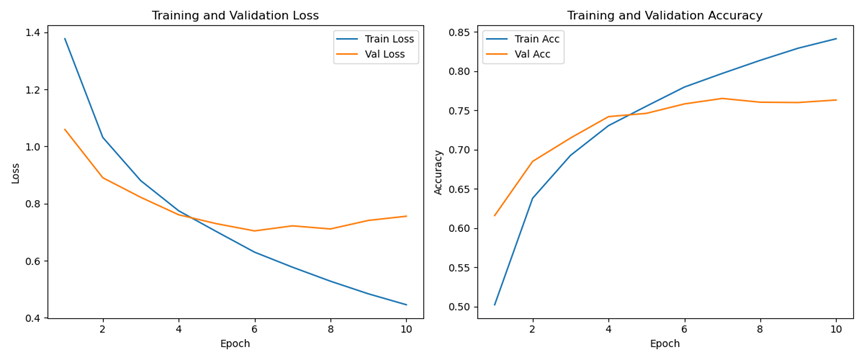
Trial (3)
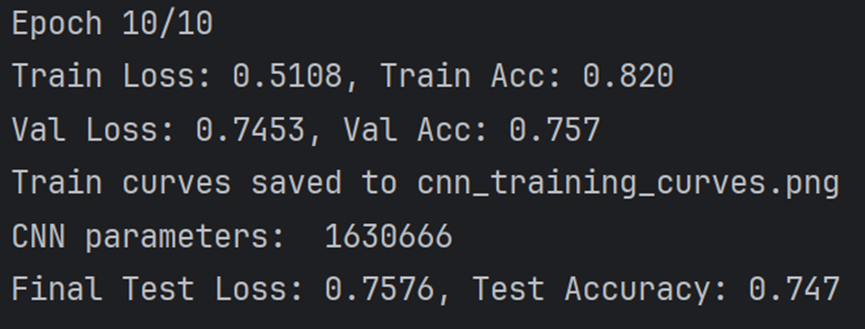
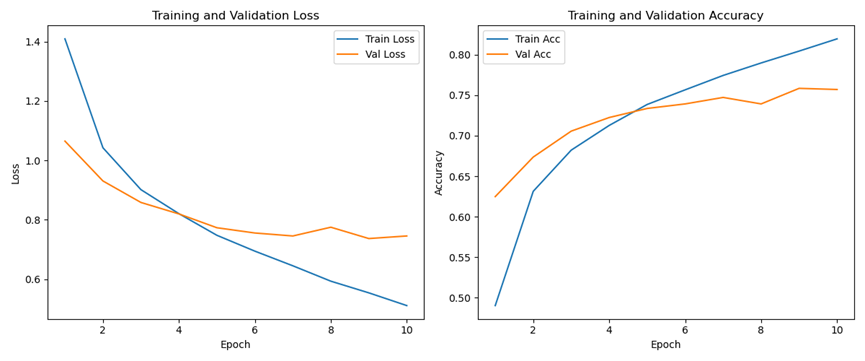
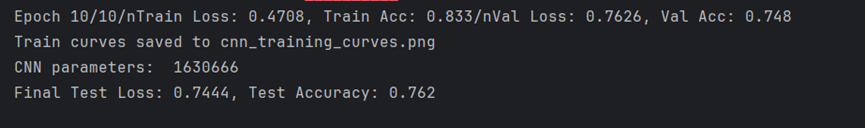

**Part D: Analysis and Discussion**

Provide performance comparison of the two models.
1. Performance Comparison:
• Generate a single plot displaying the validation accuracy curves for both the MLP and the CNN over the
10 epochs. The y-axis should be ”Validation Accuracy” and the x-axis ”Epoch”.
• Generate a second plot for the validation loss curves, formatted similarly.
• Report the final test accuracies of both models in a clearly formatted table.
2. Model Complexity:
• Implement a Python function that counts and returns the total number of trainable parameters for a given
PyTorch model.
• Use this function to obtain the parameter counts for your MLP and CNN. Present the results in a table.
3. Discussion: Discuss why the CNN outperformed the MLP in image classification.

In [ ]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from PartB_MLP import MLP
from PartC_CNN import CNN
from PartA_Data_Loader import get_dataloaders
from evaluation import evaluate
from evaluation import count_parameters

mlp_history = torch.load("mlp_history.pth")
cnn_history = torch.load("cnn_history.pth")

def plot_comparison(mlp_history, cnn_history):
    epochs = range(1, len(mlp_history["val_acc"]) + 1)

    # Validation Accuracy
    plt.figure(figsize=(10,4))
    plt.plot(epochs, mlp_history["val_acc"], label="MLP")
    plt.plot(epochs, cnn_history["val_acc"], label="CNN")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy Comparison")
    plt.legend()
    plt.savefig("val_accuracy_comparison.png")
    plt.show()

    # Validation Loss
    plt.figure(figsize=(10,4))
    plt.plot(epochs, mlp_history["val_loss"], label="MLP")
    plt.plot(epochs, cnn_history["val_loss"], label="CNN")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title("Validation Loss Comparison")
    plt.legend()
    plt.savefig("val_loss_comparison.png")
    plt.show()

plot_comparison(mlp_history, cnn_history)

# test set
train_loader, val_loader, test_loader = get_dataloaders(batch_size=64)

mlp = MLP()
mlp.load_state_dict(torch.load("mlp_model.pth"))
mlp.eval()

cnn = CNN()
cnn.load_state_dict(torch.load("cnn_model.pth"))
cnn.eval()

mlp_test_loss, mlp_test_acc = evaluate(mlp, test_loader)
cnn_test_loss, cnn_test_acc = evaluate(cnn, test_loader)

results = pd.DataFrame({
    "Model": ["MLP", "CNN"],
    "Test Accuracy": [mlp_test_acc, cnn_test_acc]
})
print("\nFinal Test Accuracy:")
print(results.to_string(index=False))

param_table = pd.DataFrame({
    "Model": ["MLP", "CNN"],
    "Trainable Parameters": [count_parameters(mlp), count_parameters(cnn)]
})
print("\nModel Complexity:")
print(param_table.to_string(index=False))

**Accuracy Comparison**

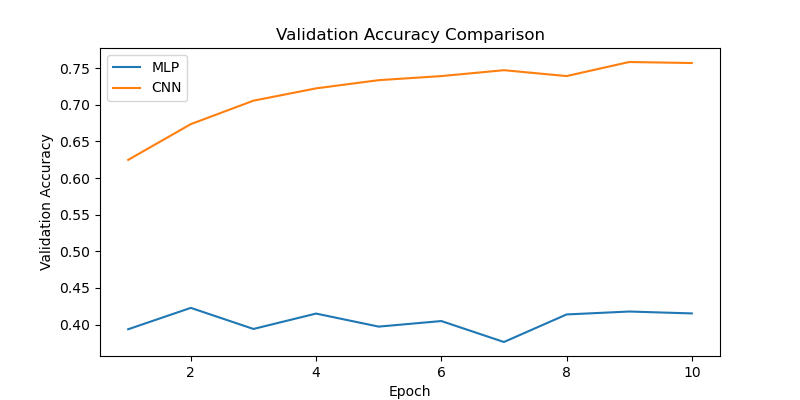

**Loss Comparison**

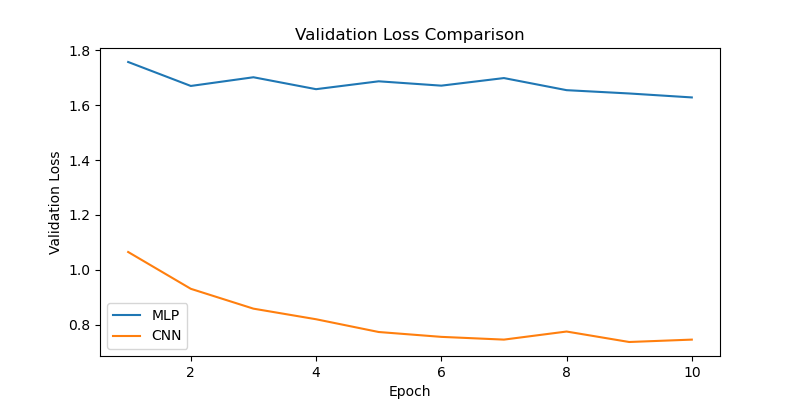

**Table of Test Accuracy and Parameters**

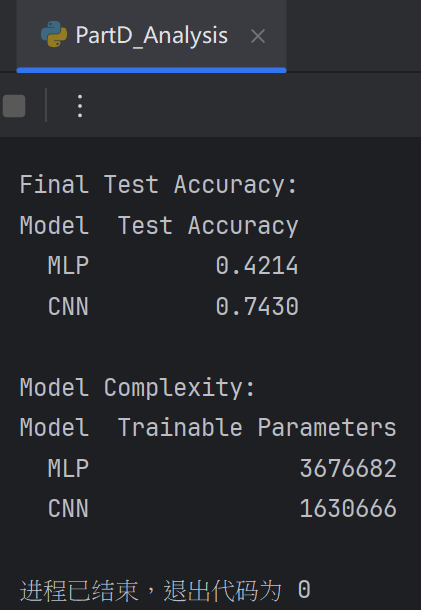
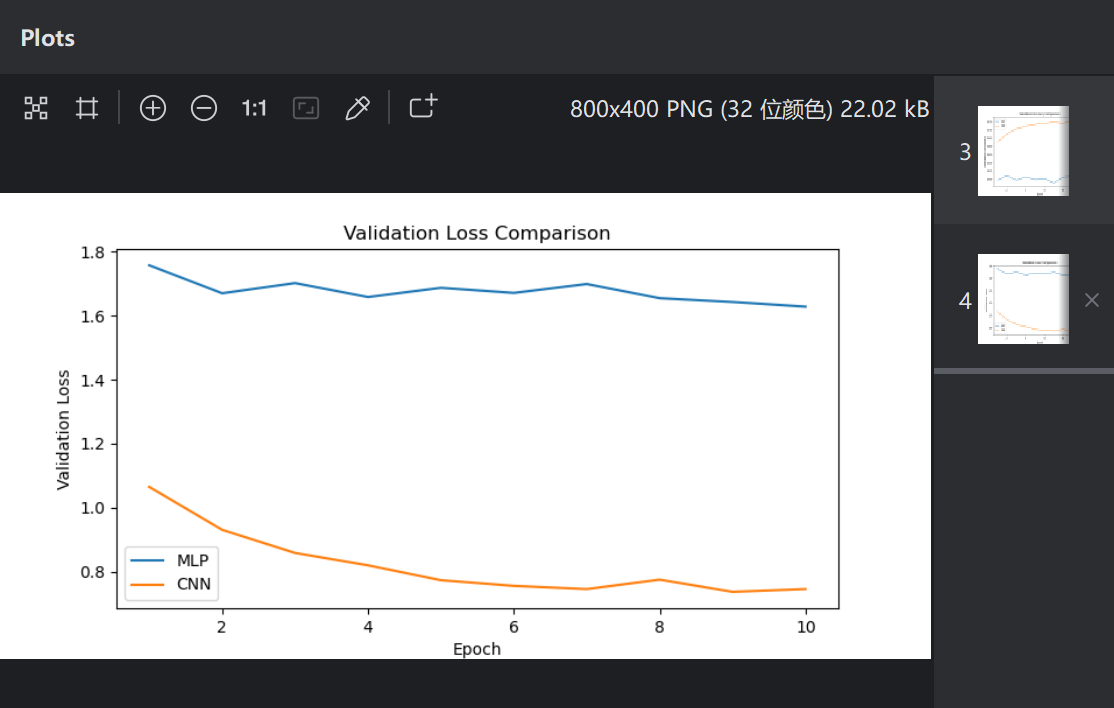

**Discussion**

CNN significantly outperforms MLP in image classification, due to its ability to capture spatial features through convolutional layers. It uses fewer parameters thanks to weight sharing, and pooling layers provide translation invariance. CNNs also learn hierarchical features, from edges to object shapes, making them ideal for visual tasks. In contrast, MLPs flatten the image and lose spatial relationships, requiring more parameters and often overfitting.